# IPCA Asset Pricing - Gu et al. (2020) Dataset (FIXED)

## Replication of Kelly, Pruitt, Su (2020) Section 8.2

**Key Fix**: Lagged characteristics - using $z_{t-1}$ to predict $r_t$

### Paper Methodology (footnote 41):
> "We use lagged firm characteristics to instrument for the conditional systematic risk loadings ($c_{i,t} = z_{i,t-1}$)"

### Paper Results (Table 2):
| Sample | Total $R^2$ | Predictive $R^2$ |
|--------|-------------|------------------|
| Incumbent stocks (in-sample) | 15.66% | 0.25% |
| New listings (out-of-sample) | 13.44% | 0.22% |

In [1]:
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

from ipca import ipca

print("Libraries loaded.")

Libraries loaded.


## 1. Load Data

In [2]:
%%time
print("Loading datashare.csv...")
datashare = pd.read_csv('../data/datashare.csv', low_memory=False)
datashare['YYYYMM'] = datashare['DATE'] // 100
print(f"Datashare: {len(datashare):,} rows")

Loading datashare.csv...
Datashare: 3,760,208 rows
CPU times: user 41.1 s, sys: 4.15 s, total: 45.3 s
Wall time: 46.6 s


In [3]:
%%time
print("Loading crsp_monthly_returns.csv...")
crsp = pd.read_csv('../data/crsp_monthly_returns.csv', usecols=['PERMNO', 'YYYYMM', 'MthRet'])
crsp = crsp.dropna(subset=['MthRet'])
crsp = crsp.rename(columns={'PERMNO': 'permno', 'MthRet': 'ret'})
print(f"CRSP: {len(crsp):,} rows")

Loading crsp_monthly_returns.csv...
CRSP: 3,962,057 rows
CPU times: user 5.57 s, sys: 332 ms, total: 5.9 s
Wall time: 5.91 s


## 2. Create Lagged Characteristics

**Critical**: Characteristics at time $t$ predict returns at time $t+1$

In [4]:
# Create next month's YYYYMM for merging
# Characteristics at YYYYMM will be matched with returns at YYYYMM_next

def next_month(yyyymm):
    """Calculate next month's YYYYMM"""
    year = yyyymm // 100
    month = yyyymm % 100
    if month == 12:
        return (year + 1) * 100 + 1
    else:
        return year * 100 + (month + 1)

print("Creating lagged merge key...")
datashare['YYYYMM_next'] = datashare['YYYYMM'].apply(next_month)
print(f"Example: Characteristics from {datashare['YYYYMM'].iloc[0]} → Returns at {datashare['YYYYMM_next'].iloc[0]}")

Creating lagged merge key...
Example: Characteristics from 195703 → Returns at 195704


Example: Characteristics from 195703 → Returns at 195704


In [5]:
%%time
# Merge: characteristics at t with returns at t+1
print("Merging with LAGGED characteristics...")
print("  datashare.YYYYMM_next = crsp.YYYYMM (char at t, ret at t+1)")

df = datashare.merge(
    crsp,
    left_on=['permno', 'YYYYMM_next'],
    right_on=['permno', 'YYYYMM'],
    how='inner',
    suffixes=('_char', '_ret')
)

# Keep the return date as the main date
df['YYYYMM'] = df['YYYYMM_ret']
df = df.drop(columns=['DATE', 'YYYYMM_char', 'YYYYMM_next', 'YYYYMM_ret'])

print(f"\nMerged: {len(df):,} observations")
print(f"Unique stocks: {df['permno'].nunique():,}")

del datashare, crsp
gc.collect()

Merging with LAGGED characteristics...
  datashare.YYYYMM_next = crsp.YYYYMM (char at t, ret at t+1)

Merged: 3,770,311 observations
Unique stocks: 29,807
CPU times: user 951 ms, sys: 1.05 s, total: 2 s
Wall time: 2.01 s


0

In [6]:
# Filter to 1965-2016
df = df[(df['YYYYMM'] >= 198501) & (df['YYYYMM'] <= 201512)]
print(f"After filtering to 1965-2016: {len(df):,} observations")
print(f"Date range: {df['YYYYMM'].min()} to {df['YYYYMM'].max()}")

After filtering to 1965-2016: 2,596,642 observations
Date range: 198501 to 201512


In [7]:
# Identify characteristics
EXCLUDE_COLS = ['permno', 'YYYYMM', 'ret', 'sic2']
CHAR_COLS = [c for c in df.columns if c not in EXCLUDE_COLS]
print(f"Characteristics: {len(CHAR_COLS)}")

Characteristics: 94


## 2.1 Check if Data is Already Rank-Transformed

Before applying rank transformation, let's check the current distribution of characteristics to see if they are already transformed.

In [8]:
# Check if characteristics are already rank-transformed
# If already transformed, values should be roughly uniform in [-0.5, 0.5]

print("Checking if characteristics are already rank-transformed...")
print("="*70)

# Sample a few characteristics to check
sample_chars = CHAR_COLS[:5]

for col in sample_chars:
    col_data = df[col].dropna()
    print(f"\n{col}:")
    print(f"  Min: {col_data.min():.4f}, Max: {col_data.max():.4f}")
    print(f"  Mean: {col_data.mean():.4f}, Std: {col_data.std():.4f}")
    print(f"  Quantiles [5%, 25%, 50%, 75%, 95%]: {col_data.quantile([0.05, 0.25, 0.5, 0.75, 0.95]).values.round(4)}")

# Check if values are already in [-0.5, 0.5] range
all_in_range = True
for col in CHAR_COLS:
    col_data = df[col].dropna()
    if col_data.min() < -0.6 or col_data.max() > 0.6:
        all_in_range = False
        break

print("\n" + "="*70)
if all_in_range:
    print("DATA APPEARS TO BE ALREADY RANK-TRANSFORMED (values in ~[-0.5, 0.5])")
    print("Skipping rank transformation may be appropriate.")
else:
    print("DATA IS NOT RANK-TRANSFORMED (values outside [-0.5, 0.5] range)")
    print("Rank transformation will be applied.")
print("="*70)

Checking if characteristics are already rank-transformed...

mvel1:
  Min: 0.0000, Max: 113589618.9800
  Mean: 1368742.2470, Std: 5308886.0833
  Quantiles [5%, 25%, 50%, 75%, 95%]: [4.85625000e+03 3.17963125e+04 1.29487562e+05 5.89236957e+05
 5.75177798e+06]

beta:
  Min: -1.9333, Max: 3.9872
  Mean: 1.0054, Std: 0.6875
  Quantiles [5%, 25%, 50%, 75%, 95%]: [0.0626 0.5008 0.9223 1.3987 2.2955]

betasq:
  Min: 0.0000, Max: 15.8978
  Mean: 1.4885, Std: 1.8653
  Quantiles [5%, 25%, 50%, 75%, 95%]: [0.0112 0.2591 0.8559 1.9616 5.2791]

chmom:
  Min: -9.0625, Max: 8.0830
  Mean: -0.0007, Std: 0.5611
  Quantiles [5%, 25%, 50%, 75%, 95%]: [-0.8109 -0.2419 -0.0071  0.231   0.8423]

dolvol:
  Min: -3.0603, Max: 19.0057
  Mean: 11.2328, Std: 2.9329
  Quantiles [5%, 25%, 50%, 75%, 95%]: [ 6.4832  9.2112 11.1939 13.3048 16.077 ]

DATA IS NOT RANK-TRANSFORMED (values outside [-0.5, 0.5] range)
Rank transformation will be applied.


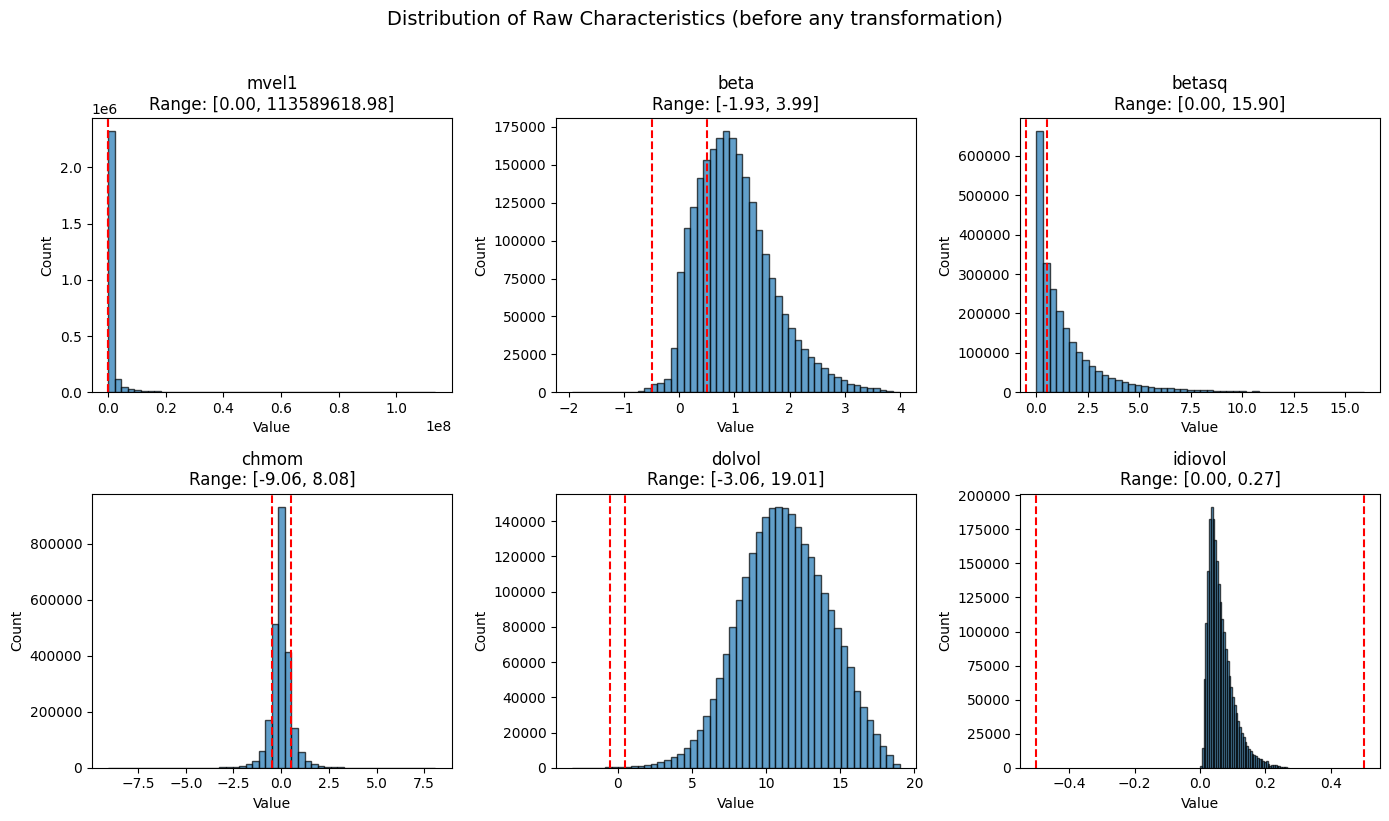

In [9]:
# Visualize distribution of a few characteristics
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(CHAR_COLS[:6]):
    ax = axes[i]
    col_data = df[col].dropna()
    ax.hist(col_data, bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(-0.5, color='r', linestyle='--', label='[-0.5, 0.5] bounds')
    ax.axvline(0.5, color='r', linestyle='--')
    ax.set_title(f'{col}\nRange: [{col_data.min():.2f}, {col_data.max():.2f}]')
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')

plt.suptitle('Distribution of Raw Characteristics (before any transformation)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 3. Rank Transformation

**Note**: Check the diagnostic output above to determine if this transformation is needed. If the data is already rank-transformed (values in [-0.5, 0.5]), you may skip this section.

The Gu et al. (2020) `datashare.csv` dataset typically contains **raw** characteristic values that need to be rank-transformed cross-sectionally each month.

In [10]:
%%time
print("Transforming to cross-sectional ranks [-0.5, 0.5]...")

df_ranked = df.copy()
for i, col in enumerate(CHAR_COLS):
    if (i + 1) % 20 == 0:
        print(f"  {i+1}/{len(CHAR_COLS)}: {col}")
    df_ranked[col] = df.groupby('YYYYMM')[col].transform(
        lambda x: (x.rank(method='average', na_option='keep') - 1) / max(x.count() - 1, 1) - 0.5
        if x.count() > 1 else 0
    )
    df_ranked[col] = df_ranked[col].fillna(0)

print("Done.")
del df
gc.collect()

Transforming to cross-sectional ranks [-0.5, 0.5]...
  20/94: cashdebt
  40/94: herf
  60/94: rd
  80/94: nincr
Done.
CPU times: user 27 s, sys: 3.85 s, total: 30.9 s
Wall time: 31.5 s


0

  80/94: nincr


Done.
CPU times: user 37.9 s, sys: 5.61 s, total: 43.5 s
Wall time: 43.7 s


0

## 4. Identify New Listings

In [11]:
# IPO = first appearance
first_appearance = df_ranked.groupby('permno')['YYYYMM'].min().reset_index()
first_appearance.columns = ['permno', 'ipo_yyyymm']
df_ranked = df_ranked.merge(first_appearance, on='permno', how='left')

# Months since IPO
df_ranked['months_since_ipo'] = (
    (df_ranked['YYYYMM'] // 100 - df_ranked['ipo_yyyymm'] // 100) * 12 +
    (df_ranked['YYYYMM'] % 100 - df_ranked['ipo_yyyymm'] % 100)
)

is_new_listing = df_ranked['months_since_ipo'] < 12
df_ranked = df_ranked.drop(columns=['ipo_yyyymm', 'months_since_ipo'])

print(f"Incumbent: {(~is_new_listing).sum():,} ({(~is_new_listing).mean()*100:.1f}%)")
print(f"New listings: {is_new_listing.sum():,} ({is_new_listing.mean()*100:.1f}%)")

Incumbent: 2,307,110 (88.8%)
New listings: 289,532 (11.2%)


In [12]:
df_incumbent = df_ranked[~is_new_listing].copy()
df_new_listings = df_ranked[is_new_listing].copy()

del df_ranked
gc.collect()

0

## 5. Prepare IPCA Format

In [13]:
def prepare_ipca(df, char_cols):
    df = df.copy()
    df['date'] = pd.to_datetime(df['YYYYMM'].astype(str), format='%Y%m').dt.to_period('M')
    df_ipca = df.set_index(['date', 'permno'])[['ret'] + char_cols].dropna(subset=['ret'])
    return df_ipca

df_ipca_incumbent = prepare_ipca(df_incumbent, CHAR_COLS)
df_ipca_new_listings = prepare_ipca(df_new_listings, CHAR_COLS)

print(f"Incumbent: {len(df_ipca_incumbent):,}")
print(f"New listings: {len(df_ipca_new_listings):,}")

del df_incumbent, df_new_listings
gc.collect()

Incumbent: 2,307,110
New listings: 289,532


58

## 6. IPCA Estimation

In [14]:
K = 4
print(f"IPCA with K={K} factors, L={len(CHAR_COLS)} characteristics")

IPCA with K=4 factors, L=94 characteristics


In [15]:
%%time
print("Fitting IPCA...")

model = ipca(RZ=df_ipca_incumbent, return_column='ret', add_constant=True)
results_is = model.fit(
    K=K,
    OOS=False,
    R_fit=True,
    Beta_fit=True,
    dispIters=True,
    dispItersInt=500,
    maxIters=10000,
    minTol=1e-5
)

Fitting IPCA...
ipca.fit finished estimation after 3 seconds and 13 iterations
CPU times: user 35.2 s, sys: 3.3 s, total: 38.5 s
Wall time: 7.67 s


ipca.fit finished estimation after 5 seconds and 13 iterations


CPU times: user 39.6 s, sys: 10.3 s, total: 50 s
Wall time: 11 s


In [16]:
Gamma_hat = results_is['Gamma']
Factor_hat = results_is['Factor']
Lambda_hat = results_is['Lambda']['estimate']

r2_total_is = results_is['rfits']['R2_Total']
r2_pred_is = results_is['rfits']['R2_Pred']

print("="*60)
print("IN-SAMPLE RESULTS")
print("="*60)
print(f"Total R²:      {r2_total_is*100:.2f}%  (paper: 15.66%)")
print(f"Predictive R²: {r2_pred_is*100:.2f}%  (paper: 0.25%)")

IN-SAMPLE RESULTS
Total R²:      14.09%  (paper: 15.66%)
Predictive R²: 0.41%  (paper: 0.25%)


## 7. Out-of-Sample Evaluation

In [17]:
def calculate_oos_r2(df_oos, Gamma, Factor, Lambda, char_cols):
    """OOS R² calculation"""
    actual = df_oos['ret'].values
    Z = df_oos[char_cols].values
    Z = np.hstack([Z, np.ones((Z.shape[0], 1))])  # add constant
    
    Gamma_np = Gamma.values
    Lambda_np = Lambda.values.flatten()
    Beta = Z @ Gamma_np
    
    factor_dates = Factor.columns
    fits_total = np.zeros(len(df_oos))
    fits_pred = np.zeros(len(df_oos))
    
    for i, (date, _) in enumerate(df_oos.index):
        if date in factor_dates:
            fits_total[i] = Beta[i] @ Factor[date].values
        else:
            fits_total[i] = Beta[i] @ Lambda_np
        fits_pred[i] = Beta[i] @ Lambda_np
    
    # R² vs zero benchmark
    ss_bench = np.sum(actual**2)
    r2_total = 1 - np.sum((actual - fits_total)**2) / ss_bench
    r2_pred = 1 - np.sum((actual - fits_pred)**2) / ss_bench
    
    return r2_total, r2_pred

r2_total_oos, r2_pred_oos = calculate_oos_r2(
    df_ipca_new_listings, Gamma_hat, Factor_hat, Lambda_hat, CHAR_COLS
)

print("="*60)
print("OUT-OF-SAMPLE RESULTS")
print("="*60)
print(f"Total R²:      {r2_total_oos*100:.2f}%  (paper: 13.44%)")
print(f"Predictive R²: {r2_pred_oos*100:.2f}%  (paper: 0.22%)")

OUT-OF-SAMPLE RESULTS
Total R²:      10.05%  (paper: 13.44%)
Predictive R²: 0.21%  (paper: 0.22%)


## 8. Final Comparison

In [18]:
print("="*70)
print("FINAL COMPARISON WITH PAPER (Table 2)")
print("="*70)
print("""
┌─────────────────────────────┬────────────┬───────────────┐
│ Sample                      │ Total R²   │ Predictive R² │
├─────────────────────────────┼────────────┼───────────────┤
│ PAPER - Incumbent           │   15.66%   │      0.25%    │
│ OURS  - Incumbent           │   {:>5.2f}%   │      {:>4.2f}%    │
├─────────────────────────────┼────────────┼───────────────┤
│ PAPER - New Listings        │   13.44%   │      0.22%    │
│ OURS  - New Listings        │   {:>5.2f}%   │      {:>4.2f}%    │
└─────────────────────────────┴────────────┴───────────────┘
""".format(r2_total_is*100, r2_pred_is*100, r2_total_oos*100, r2_pred_oos*100))

print(f"\nDataset: {len(df_ipca_incumbent) + len(df_ipca_new_listings):,} observations")
print(f"Characteristics: {len(CHAR_COLS)}")
print(f"Date range: 1965-2016")

FINAL COMPARISON WITH PAPER (Table 2)

┌─────────────────────────────┬────────────┬───────────────┐
│ Sample                      │ Total R²   │ Predictive R² │
├─────────────────────────────┼────────────┼───────────────┤
│ PAPER - Incumbent           │   15.66%   │      0.25%    │
│ OURS  - Incumbent           │   14.09%   │      0.41%    │
├─────────────────────────────┼────────────┼───────────────┤
│ PAPER - New Listings        │   13.44%   │      0.22%    │
│ OURS  - New Listings        │   10.05%   │      0.21%    │
└─────────────────────────────┴────────────┴───────────────┘


Dataset: 2,596,642 observations
Characteristics: 94
Date range: 1965-2016


In [19]:
# Save results
import json
results = {
    'K': K,
    'n_characteristics': len(CHAR_COLS),
    'n_incumbent': len(df_ipca_incumbent),
    'n_new_listings': len(df_ipca_new_listings),
    'is_total_r2': float(r2_total_is),
    'is_pred_r2': float(r2_pred_is),
    'oos_total_r2': float(r2_total_oos),
    'oos_pred_r2': float(r2_pred_oos),
    'lagged_characteristics': True
}
with open('results/asset_pricing_results_fixed.json', 'w') as f:
    json.dump(results, f, indent=2)
print("Saved: results/asset_pricing_results_fixed.json")

Saved: results/asset_pricing_results_fixed.json


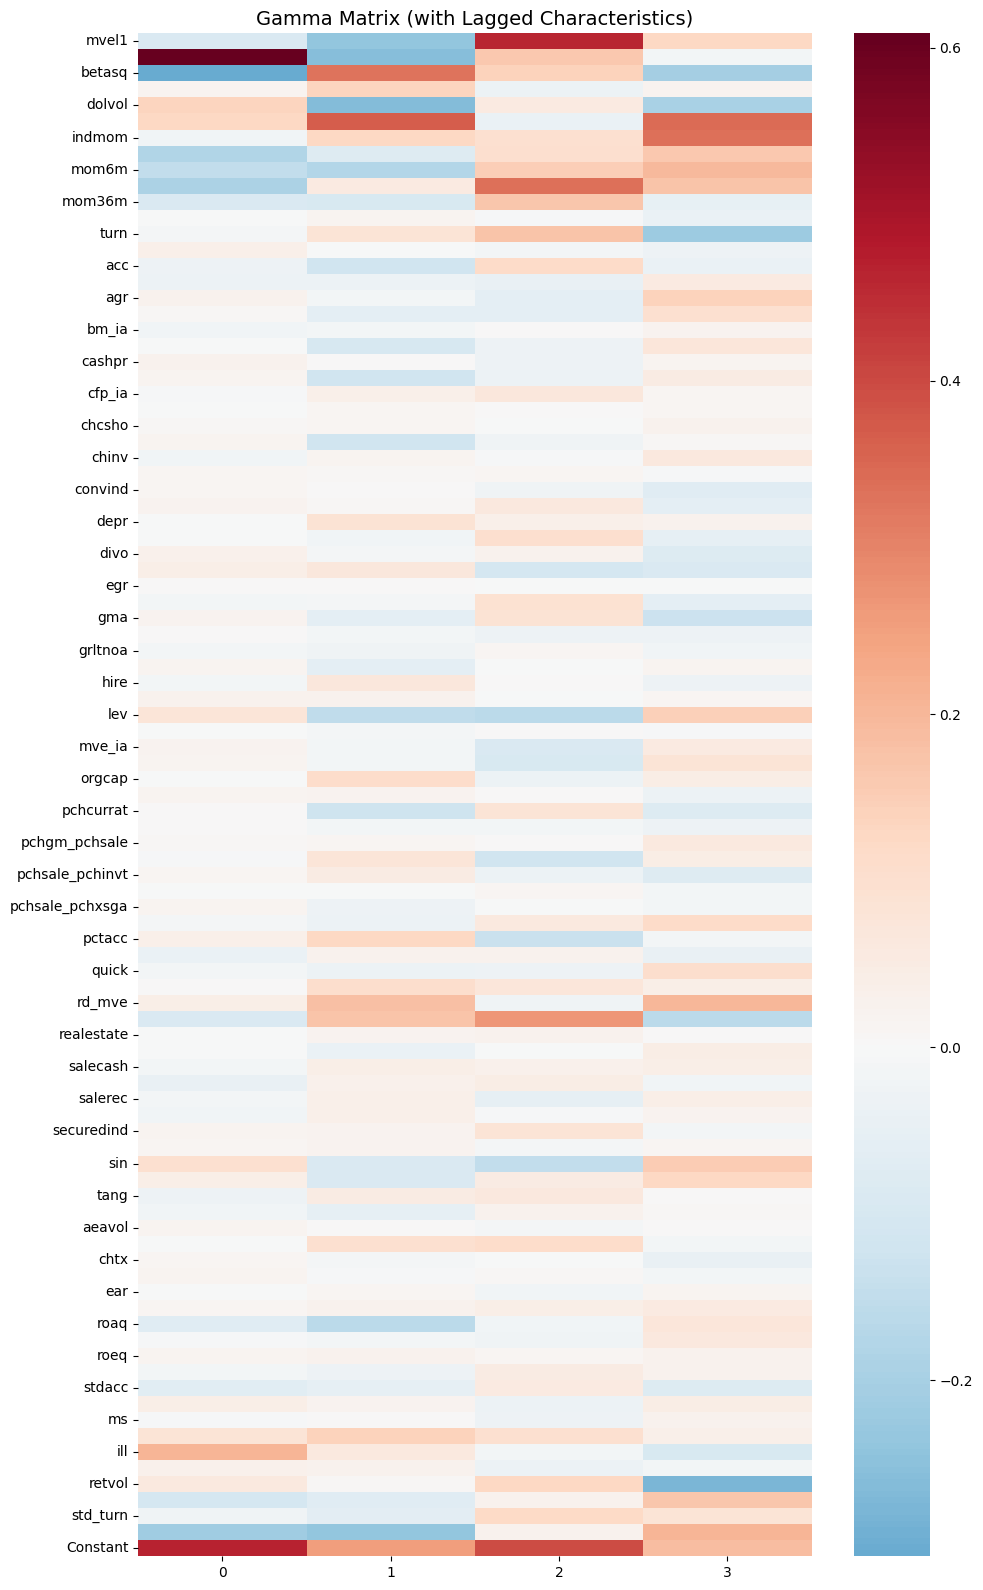

In [20]:
# Gamma heatmap
fig, ax = plt.subplots(figsize=(10, 16))
sns.heatmap(Gamma_hat, cmap='RdBu_r', center=0, ax=ax)
ax.set_title('Gamma Matrix (with Lagged Characteristics)', fontsize=14)
plt.tight_layout()
plt.savefig('results/fig_gamma_fixed.png', dpi=150)
plt.show()

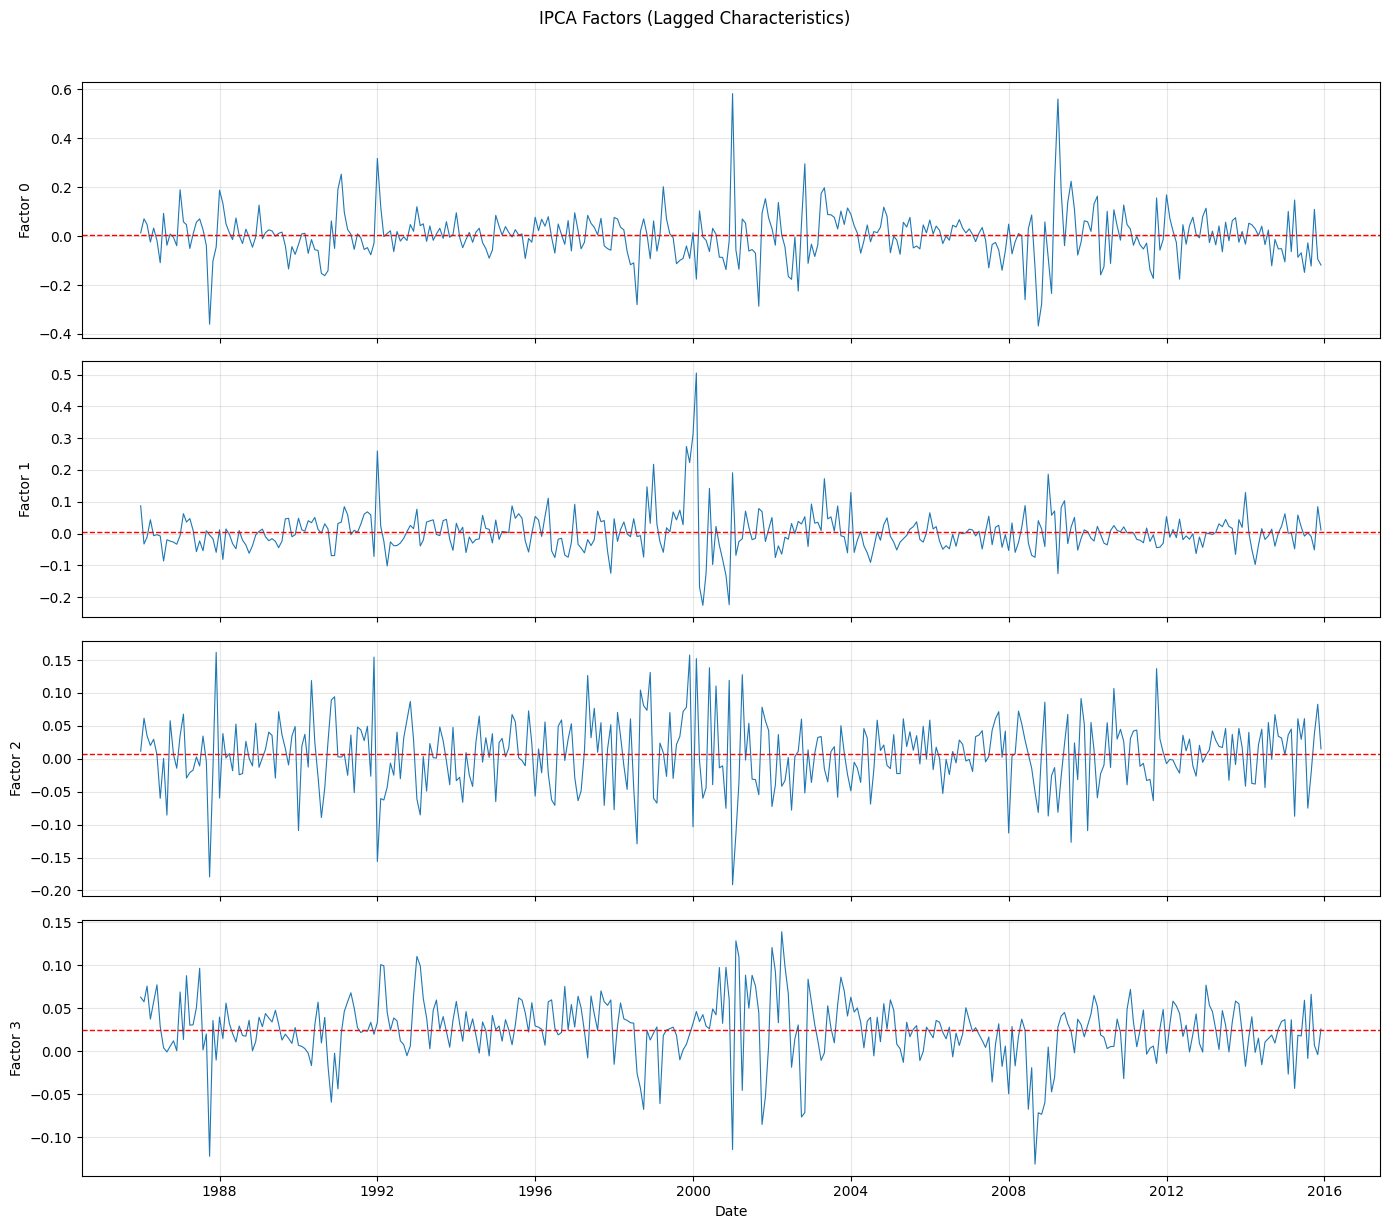

In [21]:
# Factor time series
fig, axes = plt.subplots(K, 1, figsize=(14, 3*K), sharex=True)
for i, (name, series) in enumerate(Factor_hat.iterrows()):
    ax = axes[i]
    dates = [d.to_timestamp() for d in series.index]
    ax.plot(dates, series.values, lw=0.8)
    ax.axhline(Lambda_hat.loc[name].values[0], c='r', ls='--', lw=1)
    ax.set_ylabel(f'Factor {name}')
    ax.grid(True, alpha=0.3)
axes[-1].set_xlabel('Date')
fig.suptitle('IPCA Factors (Lagged Characteristics)', y=1.02)
plt.tight_layout()
plt.savefig('results/fig_factors_fixed.png', dpi=150)
plt.show()

In [22]:
print("\nNotebook complete!")


Notebook complete!
